# Question 3: Backprop using Auto-differentiation
Purpose: To derive a version of my Network module that uses AD.

In [1]:
import numpy as np
from utils import *
from matad import *
from copy import deepcopy
import matplotlib.pyplot as plt

# Dataset

In [2]:
# DiscreteMapping dataset
n_classes = 3
in_dim = 2

np.random.seed(9201)
B = np.eye(n_classes)
A = 4.*np.random.rand(n_classes, in_dim)

ds = DiscreteMapping(A, B, n=300, noise=0.2)

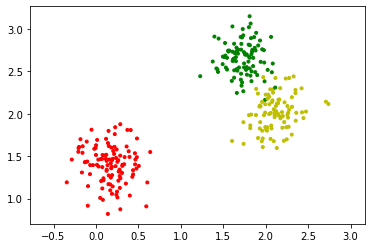

In [3]:
ds.plot()

# (a) `Mul` class and its wrapper `mul` (action required)

In [4]:
# The function "mul" is a wrapper for using the MatOperation class Mul.
def mul(a, b):
    '''
     v = mul(a, b)

     Matrix multiplication between two Mat objects.
     
     Inputs:
       a   Mat object, DxM
       b   Mat object, MxN
       
     Output:
       v   Mat object, DxN
       
     Note:
       v.creator points to the correspdoning Mul object
           of the MatOperation class
    '''
    return Mul([a, b])()

class Mul(MatOperation):
    def __init__(self, args):
        '''
         op = Mul(args)
         
         Creates a Mul object which implements matrix-matrix multiplication
         and its derivative.
         
         Inputs:
           args  list of two Mat objects
           
         Usage:
           a = Mat(...)
           b = Mat(...)
           op = Mul([a,b])  # creates the operation object
           v = op()         # evaluates the operation
        '''
        self.args = args

    def __call__(self):
        '''
         v = op() where op is a Mul object
         
         Evaluates the multiplication.
         The arguments (Mat objects) were specified at instatiation.
         
         Output:
           v   Mat containing the product
        '''
        c = Mat(self.args[0].val @ self.args[1].val)
        c.creator = self
        return c

    def backward(self, s=None):
        '''
         op.backward(s=None)
         
         Computes the derivative of the Mul operation with respect to its arguments,
         and applies that (using chain rule) to s, the input derivative.
         It then delivers the resulting derivatives to its arguments.
         
         Input:
           s  2D NumPy array (not a Mat object)
        '''
        # See assignment question 2
        self.args[0].backward(s@self.args[1].val.T)
        self.args[1].backward(self.args[0].val.T@s)


# `Layer` class and `Population` class

In [5]:
# Abstract base class for layers
class Layer(object):
    def __init__(self):
        return

    def __call__(self, x=None):
        raise NotImplementedError

In [6]:
# Population layer represents a layer of nodes, and applies the
# activation function. It also stores the input current (z) and
# the node activations (h).
class Population(Layer):
    '''
     lyr = Population(act=logistic)

     Creates a layer of nodes, and applies the activation
     to its input currents.

     Inputs:
       act  activation function
            This function should take a Mat object as input
            and output a Mat object.
          
     Usage:
       lyr.z  # Mat object, stores node input currents
       lyr.h  # Mat object, stores node activities
       lyr()  # returns lyr.h
       lyr(x) # applies activation function to x (Mat object)
    '''
    def __init__(self, act=logistic):
        self.z = None  # Mat object
        self.h = None  # Mat object
        self.act = act
        self.params = []

    def __call__(self, x=None):
        if x is not None:
            self.h = self.act(x)
        return self.h

In [7]:
class DenseLayer(Layer):
    '''
     lyr = DenseLayer(from_nodes=1, to_nodes=1, act=logistic)

     The DenseLayer class puts the connection weights and
     activation function together into a single class.
     This compound layer is composed of:
       L1: a Connection object, followed by
       L2: a Population object.

     Inputs:
       from_nodes  number of nodes in sending layer
       to_nodes    number of nodes in receiving layer
       act         activation function
                   This function should take a Mat object as input
                   and output a Mat object.

     Usage:
       lyr.L1  # Connection layer object
       lyr.L2  # Population layer object
       h1 = lyr(h0) # returns activity of receiving layer, after
       h = lyr()  # returns the activities stored in lyr.L2
    '''
    def __init__(self, from_nodes=1, to_nodes=1, act=logistic):
        self.L1 = Connection(from_nodes=from_nodes, to_nodes=to_nodes)
        self.L2 = Population(act=act)
        self.params = self.L1.params

    def __call__(self, x=None):
        if x is None:
            return self.L2.h
        else:
            return self.L2(self.L1(x))

# (b) `Connection` class (action required)

In [8]:
# Connection class
class Connection(Layer):
    '''
     lyr = Connection(from_nodes=1, to_nodes=1)

     Creates a layer of all-to-all connections.

     Inputs:
       from_nodes  number of nodes in source layer
       to_nodes    number of nodes in receiving layer
      
     Usage:
       lyr.W   # holds the connection weights (Mat object)
       lyr.b   # holds the biases (Mat object)
       lyr.params  # a list of parameters, [W,b]
       z = lyr(h)  # projects activities h (Mat) through the
                   # connection to get input currents z (Mat)
                   # ie. z = h @ W
    '''
    def __init__(self, from_nodes=1, to_nodes=1):
        super().__init__()
        self.Nin = from_nodes    # number of nodes in input (lower) layer
        self.Nout = to_nodes     # number of nodes in higher layer

        self.W = Mat( np.random.randn(self.Nin, self.Nout) / np.sqrt(self.Nin) )
        self.b = Mat( np.zeros(self.Nout) )
        self.params = [self.W, self.b]

    def __call__(self, x):
        if x is None:
            print('Should not call Connection without arguments.')
            return
        
        P = len(x)
        return mul(x, self.W) + mul(Mat(np.ones((P,1))), self.b)


# (c) `Network` class (action required)

In [9]:
class Network(object):
    '''
     net = Network()

     Creates a Network object, which represents a series of
     layers, and a cost (loss) function.

     Usage:
       net.lyr  # returns a list of Layer objects
       net.add_layer(L)  # appends the Layer L to the network
       y = net(x)  # feeds inputs x through the network
                   # x is a 2D numpy array or a Mat object
                   # returns y (Mat object)
       net.loss    # loss function (MatOperation object)
    '''
    def __init__(self):
        self.lyr = []
        self.loss = None

    def add_layer(self, L):
        self.lyr.append(L)

    def __call__(self, x):
        if type(x) not in (Mat, ):
            x = Mat(x)
        for l in self.lyr:
            x = l(x)
        return x

    def parameters(self):
        '''
         params = net.parameters()
         
         Returns a list of Mat objects of the connection weights and
         biases in the network (from bottom to top).
         Note that only Connection layers have these parameters.
        '''
        params = []
        for l in self.lyr:
            if l.params:  # skips empty lists
                params.append(l.params[0])
                params.append(l.params[1])
        return params
    
    def learn(self, ds, lrate=1., epochs=10):
        '''
         net.learn(ds, lrate=1., epochs=10)

         Runs backprop on the network, training on the data from
         the Dataset object ds.

         Inputs:
           ds       a Dataset object
           lrate    learning rate
           epochs   number of epochs to run
        '''
        x = ds.inputs()
        t = ds.targets()
        for epoch in range(epochs):
            y = self(x)
            cost = self.backprop(t, lrate=lrate)

            if epoch%50==0:
                # Report progress
                print(f'{epoch}: cost = {cost()[0,0]}')

    def backprop(self, t, lrate=1.):
        '''
         loss = net.backprop(t, lrate=1.)

         Backpropagates the loss function error gradients and
         updates the connection weights and biases.

         NOTE: This method assumes that the network state has been

         Inputs:
           t      batch of targets, one per row
           lrate  learning rate

         Output:
           loss   the cost for the batch
        '''
        
        y = self.lyr[-1]()      # network output
        loss = self.loss(y,t)   # evaluate loss
        loss.zero_grad()        # reset gradients to zero
        loss.backward()         # backpropagate gradients
        for p in self.parameters():
            p.val = p.val - lrate*p.grad  # gradient descent setp
        return loss


# Create a network

In [10]:
# Create a network object
# 2 input nodes -> 10 hidden nodes -> 3 output nodes
net = Network()
input_pop = Population(act=identity)
dl1 = DenseLayer(from_nodes=2, to_nodes=10, act=logistic)
dl2 = DenseLayer(from_nodes=10, to_nodes=3, act=logistic)
net.add_layer(input_pop)
net.add_layer(dl1)
net.add_layer(dl2)
# Loss function
net.loss = mean_ce
lrate = 1.

# Train and test the network
Your edited code should work on these lines

In [11]:
# you might have to run this a few times
net.learn(ds, lrate=lrate, epochs=500)

0: cost = 2.09402768668806
50: cost = 0.607640642113957
100: cost = 0.29225749388713174
150: cost = 0.18816092644739327
200: cost = 0.14575623537926174
250: cost = 0.12438332188981092
300: cost = 0.11203522848107376
350: cost = 0.10423091536729769
400: cost = 0.0989779222504104
450: cost = 0.0952730362669484


In [12]:
y = net.lyr[-1]().val
print(y[:6,:])

[[8.96847728e-01 1.25248844e-03 5.96106311e-02]
 [3.83954233e-05 9.98595999e-01 6.24639747e-03]
 [4.06403795e-03 3.67204902e-03 9.90458044e-01]
 [2.71069747e-02 1.58770125e-03 9.73704689e-01]
 [9.94425546e-01 7.90331256e-04 3.59283977e-03]
 [4.35144572e-05 9.94609685e-01 2.35072857e-02]]


In [13]:
ds.targets()[:6,:]

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.]])

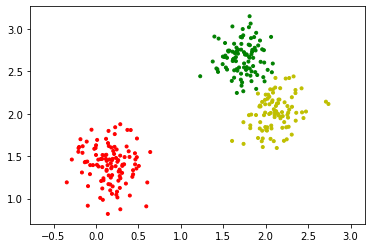

In [14]:
ds.plot(labels=y);

## You can also try your code on the `UClasses` dataset

Inputs are 2D
Targets are one-hot 2-vectors


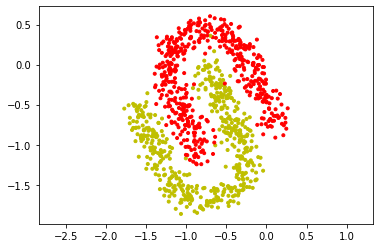

In [15]:
ds = UClasses(n=1000)
print(f'Inputs are {ds.input_dim}D')
print(f'Targets are one-hot {ds.n_classes}-vectors')
ds.plot();

In [16]:
# Create a network object
# 2 input nodes -> 10 hidden nodes -> 3 output nodes
net = Network()
input_pop = Population(act=identity)
dl1 = DenseLayer(from_nodes=2, to_nodes=20, act=logistic)
dl1b = DenseLayer(from_nodes=20, to_nodes=10, act=logistic)
dl2 = DenseLayer(from_nodes=10, to_nodes=2, act=softmax)
net.add_layer(input_pop)
net.add_layer(dl1)
net.add_layer(dl1b)
net.add_layer(dl2)
# Loss function
net.loss = categorical_ce
lrate = 1.


0: cost = 0.7215718049446509
50: cost = 0.4857256713446409
100: cost = 0.4431886352915328
150: cost = 0.4420754501702013
200: cost = 0.4460886712176054
250: cost = 0.440646322872801
300: cost = 0.439160599701368
350: cost = 0.4379237847100296
400: cost = 0.43677818332763796
450: cost = 0.4414655393310449
500: cost = 0.4331893335956797
550: cost = 0.4309228347861403
600: cost = 0.4429203063822324
650: cost = 0.42523131516018725
700: cost = 0.42813688591491755
750: cost = 0.41785036857112695
800: cost = 0.423468825659902
850: cost = 0.408592636933636
900: cost = 0.4067917201768289
950: cost = 0.4038084094863847
1000: cost = 0.3937760416811341
1050: cost = 0.389110565918743
1100: cost = 0.3862967989880417
1150: cost = 0.3811768161523024
1200: cost = 0.37536474457037566
1250: cost = 0.3702686804166915
1300: cost = 0.3656447920698721
1350: cost = 0.36099415720126204
1400: cost = 0.35499089680106183
1450: cost = 0.34870333349245286
1500: cost = 0.3412835272603448
1550: cost = 0.3334151681927

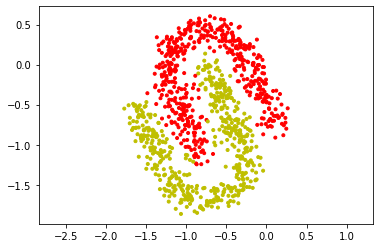

In [17]:
# You might need to run this a couple times
net.learn(ds, lrate=1., epochs=3000)
ds.plot(labels=net(ds.inputs())())
